# `Healthy Plantes Classifier`

In [6]:
# Lib & Dependencies
import os
import sys
import time
import random as rd
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

from collections import Counter
from itertools import repeat
import concurrent.futures

# import sweetviz as sv
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import VotingClassifier

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import RidgeClassifierCV
# from sklearn.neighbors import RadiusNeighborsClassifier
# from sklearn.tree import ExtraTreeClassifier


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

#### 1. Load and process data

In [7]:
# import h5py
# filename = '../data/preprocess/ALL/augmentation/export/data_all_all_graycoprops_lpb_histogram_hue_moment_haralick_histogram_hsv_histogram_lab_pyfeats.h5'

# df_features = pd.DataFrame()

# hf = h5py.File(filename, 'r')

# for f in tqdm(hf.keys()):
#     df_features[f] = list(hf[f])

# hf.close()
# df_features['classes'] = df_features.classes.apply(lambda l: l.decode("utf-8"))
# df_features = df_features.copy()
# df_features.shape

filename = '../data/preprocess/ALL/augmentation/export/data_all_all_graycoprops_lpb_histogram_hue_moment_haralick_histogram_hsv_histogram_lab_pyfeats.pkl'
df_features = pd.read_pickle(filename)
print(df_features.shape)

(190954, 1109)


##### Data normalisation

In [8]:
# %time df_features[[f for f in df_features.columns if f != 'classes']]=MinMaxScaler().fit_transform(df_features[[f for f in df_features.columns if f != 'classes']].to_numpy()).astype(np.float32)

##### Healthy Labeling

In [9]:
# Set label = (healthy or not)
df_features['label'] = df_features.classes.apply(lambda l: 1*('healthy' in l))

In [10]:
%%time 
X_train, X_test, y_train, y_test = train_test_split(df_features.drop(columns=['label','classes']), df_features['label'], test_size=0.3, random_state=42)
print(df_features.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(190954, 1110) (133667, 1108) (57287, 1108) (133667,) (57287,)
CPU times: user 1.45 s, sys: 400 ms, total: 1.85 s
Wall time: 1.93 s


In [11]:
def accuracy_classification_report(y_test, preds, col):
  confusion_mtx = {
      'y_Actual': np.array(y_test),
      'y_Predicted': preds
  }

  confusion_df = pd.DataFrame(confusion_mtx, columns=['y_Actual','y_Predicted'])    

  score = (stats.spearmanr(confusion_df['y_Actual'], confusion_df['y_Predicted']))[0]

  print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format(score))
  print('Accuracy Score :',accuracy_score(confusion_df['y_Actual'], confusion_df['y_Predicted']))
  print(classification_report(confusion_df['y_Actual'], confusion_df['y_Predicted'], target_names=col))

# Heat map : show the confusion matrix
def heat_map(preds, y_test, col, filename=''): 
    cf_matrix = confusion_matrix(y_test, preds)
    group_counts = ["{:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) \
                         for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}" for v1, v2 in \
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(len(col),len(col))
    
    cf_matrix = pd.DataFrame(cf_matrix, columns=col, index=col)
    
    # plt.figure(figsize = (32,16))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    if filename == '':
      plt.show()
    else:
      plt.savefig(filename)

# Fit the model model 
def fit_model(X_train, y_train, model_):
    print(f"======   The model used is : {model_}   ========\n")
    
    model = models[model_]
    model.fit(X_train, y_train)

    return model

# Test the prediction model 
def prediction_hackathon( X_test, y_test, model, model_, col=['Unhealthy','Healthy']):
    print(f"======   The model used is : {model_}   ========\n")
    
    if not vrb_seuil:
      # preds_train = model.predict(X_train) 
      preds = model.predict(X_test)
    else:
      # preds_train = (model.predict_proba(X_train)[:,1]>=seuil).astype(int)
      preds = (model.predict_proba(X_test)[:,1]>=seuil).astype(int)


    accuracy_classification_report(y_test, preds, col)
    
    # # Accuracy of the Test data
    print(f"\n==> Accuracy Score for the test data : {100 * accuracy_score(y_test, preds):.2f}")
        
    # Spearman correlation for the test data
    print(f"\n==> The SPEARMAN CORRELATION of the test data is : {100 * stats.spearmanr(y_test, preds)[0]:.2f}")
    
    global df_accuracy
    df_accuracy.loc[model_, 'SPEARMAN CORRELATION'] = 100 * stats.spearmanr(y_test, preds)[0]
    df_accuracy.loc[model_, 'Accuracy Score']       = 100 * accuracy_score(y_test, preds)
    df_accuracy.loc[model_, 'F1 Score macro']       = 100 * f1_score(y_test, preds, average='macro')
    df_accuracy.loc[model_, 'F1 Score weighted']    = 100 * f1_score(y_test, preds, average='weighted')
    
    # Heat Map
    heat_map(preds, y_test, col)
    # heat_map(preds, y_test, col, filename=f'plots/heatmape_{model_}.png')

In [17]:
%%time
# xgb.set_config(verbosity=3)
xgc = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric=f1_score, n_estimators=3000, n_jobs=-1)
# svc = SVC(kernel='poly', degree=6, random_state=42, cache_size=1000) # Polynomial Kernel
rfc = RandomForestClassifier(n_estimators=3000, n_jobs=-1, verbose=0)
etc = ExtraTreesClassifier(n_estimators=3000, n_jobs=-1, verbose=0)
# dtc = DecisionTreeClassifier()
# knc = KNeighborsClassifier()
# mlp = MLPClassifier(activation='relu', alpha=0.05, solver='adam', hidden_layer_sizes=(1024,256,68,16), max_iter=10000, verbose=0)
# rgc = RidgeClassifierCV()
# rnc = RadiusNeighborsClassifier()
# ett = ExtraTreeClassifier()

# vcc = VotingClassifier(estimators=[('dtc', dtc), ('etc', etc), ('xgc', xgc), ('rfc', rfc), ('mlp', mlp)], voting='hard')

seuil = 0.5
vrb_seuil = False
model_target = {}
df_accuracy  = pd.DataFrame()

# models = dict([('xgc', xgc), ('dtc', dtc), ('etc', etc), ('ett', ett), ('rfc', rfc), ('rgc', rgc), ('rnc', rnc), ('knc', knc), ('mlp', mlp), ('vcc', vcc)])
models = dict([('rfc', rfc), ('etc', etc), ('xgc', xgc)])



CPU times: user 616 µs, sys: 6 µs, total: 622 µs
Wall time: 631 µs


======   The model used is : rfc   ========

CPU times: user 2h 9min 51s, sys: 3.63 s, total: 2h 9min 55s
Wall time: 5min 1s
======   The model used is : rfc   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9777974926197305
Accuracy Score : 0.9904341299073088
              precision    recall  f1-score   support

   Unhealthy       0.99      0.99      0.99     39271
     Healthy       0.99      0.98      0.98     18016

    accuracy                           0.99     57287
   macro avg       0.99      0.99      0.99     57287
weighted avg       0.99      0.99      0.99     57287


==> Accuracy Score for the test data : 99.04

==> The SPEARMAN CORRELATION of the test data is : 97.78


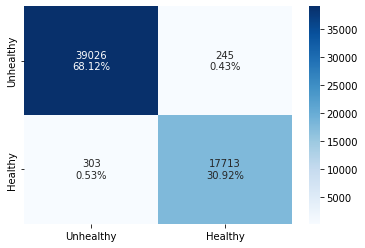

CPU times: user 1min 56s, sys: 3.45 s, total: 1min 59s
Wall time: 14.2 s
======   The model used is : etc   ========

CPU times: user 2h 28min 6s, sys: 13.9 s, total: 2h 28min 20s
Wall time: 5min 8s
======   The model used is : etc   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.97696753804795
Accuracy Score : 0.9900850105608602
              precision    recall  f1-score   support

   Unhealthy       0.99      1.00      0.99     39271
     Healthy       0.99      0.98      0.98     18016

    accuracy                           0.99     57287
   macro avg       0.99      0.99      0.99     57287
weighted avg       0.99      0.99      0.99     57287


==> Accuracy Score for the test data : 99.01

==> The SPEARMAN CORRELATION of the test data is : 97.70


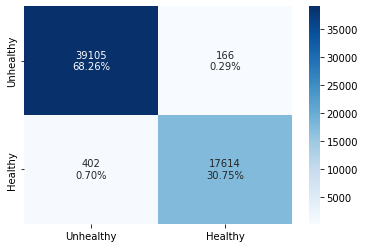

CPU times: user 2min 43s, sys: 1.9 s, total: 2min 45s
Wall time: 15.2 s
======   The model used is : xgc   ========

CPU times: user 14h 8min 16s, sys: 46.6 s, total: 14h 9min 3s
Wall time: 24min 20s
======   The model used is : xgc   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9929995012779794
Accuracy Score : 0.9969801176532197
              precision    recall  f1-score   support

   Unhealthy       1.00      1.00      1.00     39271
     Healthy       0.99      1.00      1.00     18016

    accuracy                           1.00     57287
   macro avg       1.00      1.00      1.00     57287
weighted avg       1.00      1.00      1.00     57287


==> Accuracy Score for the test data : 99.70

==> The SPEARMAN CORRELATION of the test data is : 99.30


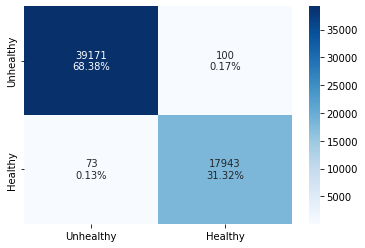

CPU times: user 9 s, sys: 179 ms, total: 9.18 s
Wall time: 493 ms
     SPEARMAN CORRELATION  Accuracy Score  F1 Score macro  F1 Score weighted
rfc             97.779749       99.043413       98.889738          99.042995
etc             97.696754       99.008501       98.846109          99.006718
xgc             99.299950       99.698012       99.649945          99.698073


In [16]:
for md_ in models.keys():
     %time model_target[md_] = fit_model(X_train, y_train, md_)
     %time prediction_hackathon( X_test, y_test, model_target[md_], md_)

print(df_accuracy)

======   The model used is : sgdb   ========



/home/dev/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


CPU times: user 5min 8s, sys: 756 ms, total: 5min 9s
Wall time: 5min 9s
======   The model used is : sgdb   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.5358195972445903
Accuracy Score : 0.8008797807530504
              precision    recall  f1-score   support

   Unhealthy       0.85      0.86      0.86     39271
     Healthy       0.69      0.67      0.68     18016

    accuracy                           0.80     57287
   macro avg       0.77      0.77      0.77     57287
weighted avg       0.80      0.80      0.80     57287


==> Accuracy Score for the test data : 80.09

==> The SPEARMAN CORRELATION of the test data is : 53.58


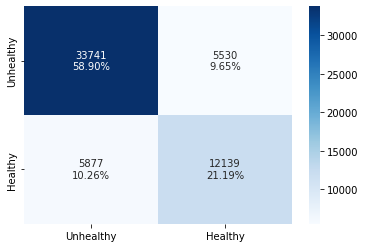

CPU times: user 1.26 s, sys: 1.07 s, total: 2.33 s
Wall time: 939 ms
      SPEARMAN CORRELATION  Accuracy Score  F1 Score macro  F1 Score weighted
sgdb              53.58196       80.087978       76.787315          80.034958


In [19]:
from sklearn.linear_model import SGDClassifier

sgdb = SGDClassifier(loss='squared_hinge',n_jobs=-1)

models = dict([('sgdb', sgdb)])
for md_ in models.keys():
    %time model_target[md_] = fit_model(X_train, y_train, md_)
    %time prediction_hackathon( X_test, y_test, model_target[md_], md_)

print(df_accuracy)

======   The model used is : svcp5   ========

CPU times: user 58min 31s, sys: 4.33 s, total: 58min 36s
Wall time: 58min 44s
======   The model used is : svcp5   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9142210237164294
Accuracy Score : 0.9630108052437726
              precision    recall  f1-score   support

   Unhealthy       0.97      0.97      0.97     39271
     Healthy       0.94      0.94      0.94     18016

    accuracy                           0.96     57287
   macro avg       0.96      0.96      0.96     57287
weighted avg       0.96      0.96      0.96     57287


==> Accuracy Score for the test data : 96.30

==> The SPEARMAN CORRELATION of the test data is : 91.42


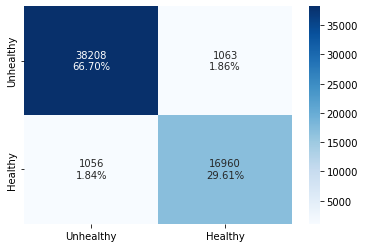

CPU times: user 18min 21s, sys: 1.37 s, total: 18min 23s
Wall time: 18min 25s
======   The model used is : svcp6   ========

CPU times: user 52min 41s, sys: 1.14 s, total: 52min 43s
Wall time: 52min 52s
======   The model used is : svcp6   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9226664213015989
Accuracy Score : 0.9666591024141603
              precision    recall  f1-score   support

   Unhealthy       0.98      0.98      0.98     39271
     Healthy       0.95      0.95      0.95     18016

    accuracy                           0.97     57287
   macro avg       0.96      0.96      0.96     57287
weighted avg       0.97      0.97      0.97     57287


==> Accuracy Score for the test data : 96.67

==> The SPEARMAN CORRELATION of the test data is : 92.27


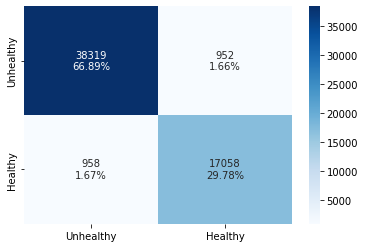

CPU times: user 15min 48s, sys: 205 ms, total: 15min 48s
Wall time: 15min 52s
======   The model used is : svcp7   ========

CPU times: user 50min 41s, sys: 599 ms, total: 50min 42s
Wall time: 50min 51s
======   The model used is : svcp7   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.928562172693763
Accuracy Score : 0.9691902176759125
              precision    recall  f1-score   support

   Unhealthy       0.98      0.98      0.98     39271
     Healthy       0.95      0.95      0.95     18016

    accuracy                           0.97     57287
   macro avg       0.96      0.96      0.96     57287
weighted avg       0.97      0.97      0.97     57287


==> Accuracy Score for the test data : 96.92

==> The SPEARMAN CORRELATION of the test data is : 92.86


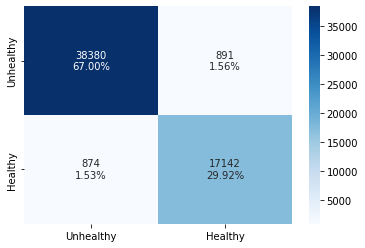

CPU times: user 15min 6s, sys: 260 ms, total: 15min 6s
Wall time: 15min 9s
======   The model used is : svcp8   ========

CPU times: user 53min 12s, sys: 742 ms, total: 53min 12s
Wall time: 53min 23s
======   The model used is : svcp8   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.934421986735952
Accuracy Score : 0.9717213329376647
              precision    recall  f1-score   support

   Unhealthy       0.98      0.98      0.98     39271
     Healthy       0.95      0.96      0.96     18016

    accuracy                           0.97     57287
   macro avg       0.97      0.97      0.97     57287
weighted avg       0.97      0.97      0.97     57287


==> Accuracy Score for the test data : 97.17

==> The SPEARMAN CORRELATION of the test data is : 93.44


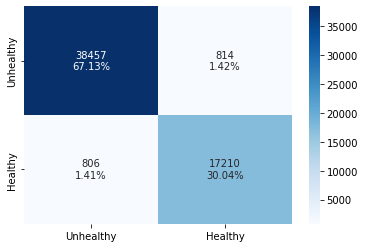

CPU times: user 17min 8s, sys: 496 ms, total: 17min 9s
Wall time: 17min 12s
======   The model used is : svcp9   ========

CPU times: user 46min 39s, sys: 408 ms, total: 46min 39s
Wall time: 46min 40s
======   The model used is : svcp9   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.938617185850724
Accuracy Score : 0.9735367535391973
              precision    recall  f1-score   support

   Unhealthy       0.98      0.98      0.98     39271
     Healthy       0.96      0.96      0.96     18016

    accuracy                           0.97     57287
   macro avg       0.97      0.97      0.97     57287
weighted avg       0.97      0.97      0.97     57287


==> Accuracy Score for the test data : 97.35

==> The SPEARMAN CORRELATION of the test data is : 93.86


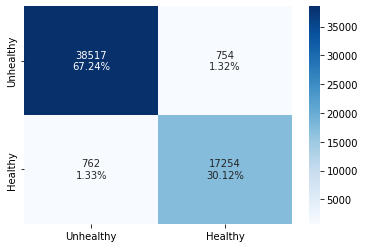

CPU times: user 11min 13s, sys: 278 ms, total: 11min 13s
Wall time: 11min 13s
======   The model used is : svcp10   ========

CPU times: user 45min 5s, sys: 327 ms, total: 45min 5s
Wall time: 45min 5s
======   The model used is : svcp10   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9413402277776739
Accuracy Score : 0.9747237593171225
              precision    recall  f1-score   support

   Unhealthy       0.98      0.98      0.98     39271
     Healthy       0.96      0.96      0.96     18016

    accuracy                           0.97     57287
   macro avg       0.97      0.97      0.97     57287
weighted avg       0.97      0.97      0.97     57287


==> Accuracy Score for the test data : 97.47

==> The SPEARMAN CORRELATION of the test data is : 94.13


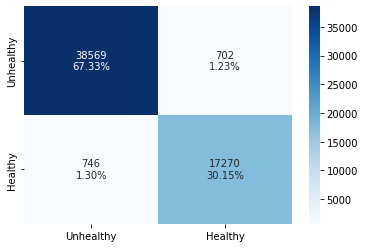

CPU times: user 11min 11s, sys: 247 ms, total: 11min 11s
Wall time: 11min 11s
======   The model used is : svcp11   ========

CPU times: user 45min 12s, sys: 405 ms, total: 45min 12s
Wall time: 45min 12s
======   The model used is : svcp11   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9427298775499104
Accuracy Score : 0.9753347181734076
              precision    recall  f1-score   support

   Unhealthy       0.98      0.98      0.98     39271
     Healthy       0.96      0.96      0.96     18016

    accuracy                           0.98     57287
   macro avg       0.97      0.97      0.97     57287
weighted avg       0.98      0.98      0.98     57287


==> Accuracy Score for the test data : 97.53

==> The SPEARMAN CORRELATION of the test data is : 94.27


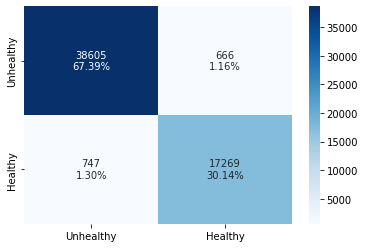

CPU times: user 10min 58s, sys: 216 ms, total: 10min 59s
Wall time: 10min 58s
======   The model used is : svcp12   ========

CPU times: user 47min 23s, sys: 430 ms, total: 47min 23s
Wall time: 47min 23s
======   The model used is : svcp12   ========

Score as calculated for the leader board (っಠ‿ಠ)っ 0.9422487948881371
Accuracy Score : 0.9751601585001833
              precision    recall  f1-score   support

   Unhealthy       0.98      0.98      0.98     39271
     Healthy       0.97      0.96      0.96     18016

    accuracy                           0.98     57287
   macro avg       0.97      0.97      0.97     57287
weighted avg       0.98      0.98      0.98     57287


==> Accuracy Score for the test data : 97.52

==> The SPEARMAN CORRELATION of the test data is : 94.22


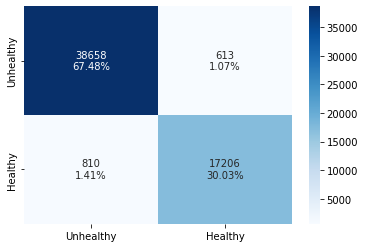

CPU times: user 10min 36s, sys: 246 ms, total: 10min 36s
Wall time: 10min 36s
        SPEARMAN CORRELATION  Accuracy Score  F1 Score macro  \
sgdb               53.581960       80.087978       76.787315   
svcp5              91.422102       96.301081       95.711049   
svcp6              92.266642       96.665910       96.133320   
svcp7              92.856217       96.919022       96.428097   
svcp8              93.442199       97.172133       96.721097   
svcp9              93.861719       97.353675       96.930857   
svcp10             94.134023       97.472376       97.066935   
svcp11             94.272988       97.533472       97.136233   
svcp12             94.224879       97.516016       97.110893   

        F1 Score weighted  
sgdb            80.034958  
svcp5           96.301275  
svcp6           96.665760  
svcp7           96.919415  
svcp8           97.172303  
svcp9           97.353516  
svcp10          97.471538  
svcp11          97.531964  
svcp12          97.512295  


In [20]:
for degree in range(5,13):
    svcp = SVC(kernel='poly', degree=degree, random_state=42) # Polynomial Kernel
    models = dict([(f'svcp{degree}', svcp)])
    for md_ in models.keys():
        %time model_target[md_] = fit_model(X_train, y_train, md_)
        %time prediction_hackathon( X_test, y_test, model_target[md_], md_)

print(df_accuracy)

In [ ]:
# Stop execution before submission !!!
raise SystemExit("Stop right there!")

##### SVM model

In [ ]:
%%time

# svcg = SVC(kernel='rbf', probability=True, random_state=42) # Gaussien Kernel
# svcp3 = SVC(kernel='poly', degree=3, probability=True, random_state=42) # Polynomial Kernel

# models = dict([('svcp3', svcp3)])

for kernel in ['rbf', 'sigmoid', 'poly', 'linear']:
  svcp = SVC(kernel=kernel, random_state=42) # Polynomial Kernel
  models = dict([(f'svcp{kernel}', svcp)])
  for md in models.keys():
    %time model_target[md] = prediction_hackathon(X_train, X_test, y_train, y_test, md)

display(df_accuracy)

In [ ]:
for degree in range(2,13):
  svcp = SVC(kernel='poly', degree=degree, random_state=42) # Polynomial Kernel
  models = dict([(f'svcp{degree}', svcp)])
  for md in models.keys():
    %time model_target[md] = prediction_hackathon(X_train, X_test, y_train, y_test, md)

display(df_accuracy)

### Find the SVM Classifier optimal hyperparameters

In [ ]:
# Finding optimal parameters

svc = SVC(random_state=42)

parameters = {
              'C': [.5,.7,1,1.2,1.5,2],
              'gamma': ['scale'],
              'kernel': ['poly'],
              'degree': [6],              
            }

grid = GridSearchCV(estimator  = svc, scoring="f1", refit=True, 
                          param_grid = parameters, 
                          cv = 5, verbose = 10, 
                          n_jobs = -1)

# grid = RandomizedSearchCV(estimator  = etc, scoring="f1_weighted",
#                           param_distributions = parameters, 
#                           n_iter = 500, cv = 3, verbose = 2, 
#                           random_state = 42, n_jobs = -1)

grid.fit(X_train, y_train)

# Dictionary of best parameters
best_pars = grid.best_params_
print(best_pars)

# Best ETC model that was found based on the metric score you specify
best_model = grid.best_estimator_

# # Save model
# pickle.dump(grid.best_estimator_, open("xgb_log_reg.pickle", "wb"))

models = dict([('best_model', best_model)])

for md in models.keys():
  %time model_target[md] = prediction_hackathon(X_train, X_test, y_train, y_test, md)

print(df_accuracy)

### Find the XGBoost optimal hyperparameters
[Paramètres XGBoost](https://xgboost.readthedocs.io/en/latest/parameter.html#additional-parameters-for-hist-and-gpu-hist-tree-method)

In [ ]:
# Finding optimal parameters

xgc = xgb.XGBClassifier(use_label_encoder=False, objective='multi:softmax', eval_metric='mlogloss', n_jobs=-1, verbosity=2)

parameters = {
     "booster"          : ["gbtree", "gblinear", "dart"],
     "eta"              : [0.001, 0.01, 0.1, 0.30, 0.4] ,
     "max_depth"        : [ 3, 4, 5, 6],
     "min_child_weight" : [ 1, 5, 7],
     "gamma"            : [ 0, 0.1, 0.3, 0.5, 0.7, 1],
     "colsample_bytree" : [ 0.1, 0.3, 0.5, 1],
     "n_estimators"     : [50, 100, 150],
     "subsample"        : [0.5, 1],
     "tree_method"      : ["auto","hist","gpu_hist"],
     "reg_alpha"        : [0, 1e-5, 1e-2, 0.1, 1]
     }
# grid = GridSearchCV(xgc,
#                     parameters, n_jobs=-1,
#                     scoring="roc_auc",
#                     cv=2)

grid = RandomizedSearchCV(estimator  = xgc, scoring="f1_weighted",
                          param_distributions = parameters, 
                          n_iter = 500, cv = 3, verbose = 2, 
                          random_state = 42, n_jobs = -1)

# Finding the optimal parameters
X_optrain, X_optest, y_optrain, y_optest = train_test_split(df_all[col1+col_ho], df_all['cow_state'].astype(int), train_size=0.1, random_state=42)
print(X_optrain.shape, X_optest.shape, y_optrain.shape, y_optest.shape)

grid.fit(X_optrain, y_optrain)

# Dictionary of best parameters
best_pars = grid.best_params_
print(best_pars)

# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# # Save model
# pickle.dump(grid.best_estimator_, open("xgb_log_reg.pickle", "wb"))

models = dict([('best_model', best_model)])

%time model_target['xgc_best_model'] = prediction_hackathon(X_train, X_test, y_train, y_test, 'best_model')


In [ ]:
print(best_pars)

#### Extra Trees Classifier

In [ ]:
# Finding optimal parameters

etc  = ExtraTreesClassifier(n_jobs=-1, verbose=2)

parameters = {
              "n_estimators"      : range(50,600,50),
              # "splitter"          : ["best", "random"],
              "criterion"         : ["gini", "entropy"],
              "max_depth"         : [ 3, 4, 5, 10, 15, 20],
              "min_samples_split" : [2, 5, 10, 15, 20],
              "min_samples_leaf"  : [2, 5, 10, 15, 20],
              "max_features"      : ['auto' ,'sqrt'], 
              "bootstrap"         : [True, False],
              "max_samples"       : [i/10 for i in range(1, 11)],
              "ccp_alpha"         : [i*11/100 for i in range(1,10)]
            }

# grid = GridSearchCV(estimator  = xtc, scoring="f1_weighted",
#                           param_grid = parameters, 
#                           cv = 3, verbose = 2, 
#                           n_jobs = -1)

grid = RandomizedSearchCV(estimator  = etc, scoring="f1_weighted",
                          param_distributions = parameters, 
                          n_iter = 500, cv = 3, verbose = 2, 
                          random_state = 42, n_jobs = -1)

# Finding the optimal parameters
X_optrain, X_optest, y_optrain, y_optest = train_test_split(df_all[col1+col_ho], df_all['cow_state'].astype(int), train_size=0.1, random_state=42)
print(X_optrain.shape, X_optest.shape, y_optrain.shape, y_optest.shape)

grid.fit(X_optrain, y_optrain)

# Dictionary of best parameters
best_pars = grid.best_params_
print(best_pars)

# Best ETC model that was found based on the metric score you specify
best_model = grid.best_estimator_

# # Save model
# pickle.dump(grid.best_estimator_, open("xgb_log_reg.pickle", "wb"))

models = dict([('best_model', best_model)])



In [ ]:
seuil = 0.5
vrb_seuil = False
model_target = {}

%time model_target['etc_best_model'] = prediction_hackathon(X_train, X_test, y_train, y_test, 'best_model')

In [ ]:
print(best_pars)

#### Random Forest

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1, verbose=2)

# Grille aléatoire 
random_grid = {
                'bootstrap'         : [True, False],
                'max_depth'         : [5, 6, 7], 
                'max_features'      : ['auto', 'sqrt', 'log2'], 
                'min_samples_leaf'  : [4, 5, 6], 
                'min_samples_split' : range(8,20,2), 
                'n_estimators'      : range(8,len(col1+col_ho)+4)
               }

# Recherche dans 5000 combinaisons différentes 
rf_random = RandomizedSearchCV (estimator  = rfc, scoring="f1_macro",
                                param_distributions = random_grid, 
                                n_iter = 500, cv = 3, verbose = 2, 
                                random_state = 42, n_jobs = -1)

# Finding the optimal parameters
X_optrain, X_optest, y_optrain, y_optest = train_test_split(df_all[col1+col_ho], df_all['cow_state'].astype(int), train_size=0.1, random_state=42)
print(X_optrain.shape, X_optest.shape, y_optrain.shape, y_optest.shape)

# Ajuster le modèle de recherche aléatoire 
rf_random.fit(X_optrain, y_optrain)

# Dictionary of best parameters
best_pars = rf_random.best_params_
print(best_pars)

# Best RFC model that was found based on the metric score you specify
best_model = rf_random.best_estimator_

models = dict([('best_model', best_model)])

%time model_target['rfc_best_model'] = prediction_hackathon(X_train, X_test, y_train, y_test, 'best_model')

In [ ]:
print(best_pars)

### Select importances features

In [ ]:
xgc = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric=f1_score, n_estimators=1500, n_jobs=-1)

def rfecv_func(md):
    rfecv = RFECV(md, step=1, cv=5, n_jobs=-1, verbose=2)

    rfecv.fit(X_train, y_train)

    rfecv.get_params()

    feat_sel = pd.DataFrame({'features' : X_train.columns, 'Rank' : rfecv.ranking_})
    fit_feat = feat_sel[feat_sel.Rank == 1]['features'].values
    print(f"\n============================\nimportances fetures for {md}\n", fit_feat)

models = dict([('xgc', xgc)])

for md in ['xgc']:
    rfecv_func(models[md])

In [ ]:
cols = ['FOS_Mean','FOS_Mode','FOS_Skewness','FOS_Kurtosis'
,'FOS_MinimalGrayLevel','FOS_MaximalGrayLevel','FOS_25Percentile'
,'FOS_90Percentile','FOS_HistogramWidth','GLCM_ASM_Mean'
,'GLCM_Contrast_Mean','GLCM_Correlation_Mean'
,'GLCM_SumOfSquaresVariance_Mean','GLCM_SumAverage_Mean'
,'GLCM_SumVariance_Mean','GLCM_SumEntropy_Mean'
,'GLCM_DifferenceVariance_Mean','GLCM_DifferenceEntropy_Mean'
,'GLCM_Information2_Mean','GLCM_MaximalCorrelationCoefficient_Mean'
,'GLCM_Contrast_Range','GLCM_Correlation_Range'
,'GLCM_SumOfSquaresVariance_Range','GLCM_InverseDifferenceMoment_Range'
,'GLCM_SumAverage_Range','GLCM_SumVariance_Range','GLCM_SumEntropy_Range'
,'GLCM_Entropy_Range','GLCM_DifferenceEntropy_Range'
,'GLCM_Information1_Range','GLCM_Information2_Range'
,'GLCM_MaximalCorrelationCoefficient_Range','GLDS_Homogeneity','GLDS_ASM'
,'GLDS_Entopy','GLDS_Mean','NGTDM_Busyness','NGTDM_Strngth'
,'SFM_Periodicity','LTE_LL_7','LTE_EE_7','LTE_LE_7','LTE_ES_7','LTE_LS_7'
,'FDTA_HurstCoeff_1','FDTA_HurstCoeff_2','FDTA_HurstCoeff_3'
,'FDTA_HurstCoeff_4','GLRLM_GrayLevelNo-Uniformity','GLRLM_RunPercentage'
,'GLRLM_LowGrayLevelRunEmphasis','GLRLM_HighGrayLevelRunEmphasis'
,'GLRLM_ShortRunHighGrayLevelEmphasis'
,'GLRLM_LongRunHighGrayLevelEmphasis','FPS_RadialSum','FPS_AngularSum'
,'SHAPE_area','SHAPE_perimeter2perArea','GLSZM_SmallZoneEmphasis'
,'GLSZM_LargeZoneEmphasis','GLSZM_ZoneSizeNonuniformity'
,'GLSZM_LowGrayLeveLZoneEmphasis','GLSZM_HighGrayLevelZoneEmphasis'
,'GLSZM_SmallZoneLowGrayLevelEmphasis'
,'GLSZM_SmallZoneHighGrayLevelEmphasis'
,'GLSZM_LargeZoneHighGrayLevelEmphasis','GLSZM_GrayLevelVariance'
,'GLSZM_ZoneSizeEntropy','LBP_R_1_P_8_energy','LBP_R_1_P_8_entropy'
,'LBP_R_2_P_16_entropy','PDF1','PDF2','PDF4','PDF6','PDF7','PDF8','PDF9'
,'CDF6','pdf_L2','pdf_H1','pdf_H4','pdf_H5','pdf_H6','pdf_H7','pdf_H8'
,'cdf_L5','cdf_L8','cdf_M3','cdf_M6','cdf_M7','cdf_H5','cdf_H8'
,'Histogram_bin_0','Histogram_bin_1','Histogram_bin_2','Histogram_bin_3'
,'Histogram_bin_6','Histogram_bin_7','Histogram_erosion_1_bin_1'
,'Histogram_erosion_1_bin_3','Histogram_erosion_1_bin_4'
,'Histogram_erosion_1_bin_5','Histogram_erosion_1_bin_6'
,'Histogram_erosion_1_bin_7','Histogram_erosion_2_bin_0'
,'Histogram_erosion_2_bin_4','Histogram_erosion_2_bin_5'
,'Histogram_erosion_3_bin_0','Histogram_erosion_3_bin_1'
,'Histogram_erosion_3_bin_2','Histogram_erosion_3_bin_3'
,'Histogram_erosion_3_bin_4','Correlogram_dist_0_5','Correlogram_dist_1_0'
,'Correlogram_dist_1_1','Correlogram_dist_1_5','Correlogram_dist_2_0'
,'Correlogram_dist_2_1','Correlogram_dist_2_4','Correlogram_dist_2_5'
,'Correlogram_dist_2_6','Correlogram_dist_3_0','Correlogram_dist_3_1'
,'Correlogram_dist_3_2','Correlogram_dist_3_3','Correlogram_dist_3_5'
,'Correlogram_dist_3_6','Correlogram_dist_4_0','Correlogram_dist_4_2'
,'Correlogram_dist_4_5','Correlogram_dist_5_0','Correlogram_dist_5_1'
,'Correlogram_dist_5_2','Correlogram_dist_5_3','Correlogram_dist_5_5'
,'Correlogram_dist_5_6','Correlogram_dist_5_7','Correlogram_dist_6_0'
,'Correlogram_dist_6_1','Correlogram_dist_6_2','Correlogram_dist_6_3'
,'Correlogram_dist_6_6','Correlogram_dist_6_7','Correlogram_dist_7_0'
,'Correlogram_dist_7_1','Correlogram_dist_7_2','Correlogram_dist_7_3'
,'Correlogram_dist_7_5','Correlogram_dist_7_6','Correlogram_dist_7_7'
,'Correlogram_angl_0_3','Correlogram_angl_1_0','Correlogram_angl_1_2'
,'Correlogram_angl_2_1','Correlogram_angl_2_2','Correlogram_angl_3_2'
,'Correlogram_angl_3_3','Correlogram_angl_4_1','Correlogram_angl_5_2'
,'Correlogram_angl_5_3','Correlogram_angl_6_0','Correlogram_angl_7_4'
,'Correlogram_angl_7_5','DWT_bior3.3_level_1_da_mean'
,'DWT_bior3.3_level_1_da_std','DWT_bior3.3_level_1_dd_mean'
,'DWT_bior3.3_level_1_dd_std','DWT_bior3.3_level_1_ad_std'
,'DWT_bior3.3_level_2_da_mean','DWT_bior3.3_level_2_da_std'
,'DWT_bior3.3_level_2_dd_mean','DWT_bior3.3_level_2_dd_std'
,'DWT_bior3.3_level_2_ad_mean','DWT_bior3.3_level_2_ad_std'
,'DWT_bior3.3_level_3_dd_std','DWT_bior3.3_level_3_ad_std'
,'SWT_bior3.3_level_1_h_mean','SWT_bior3.3_level_1_d_mean'
,'SWT_bior3.3_level_1_d_std','SWT_bior3.3_level_2_d_std'
,'SWT_bior3.3_level_3_d_mean','SWT_bior3.3_level_3_d_std'
,'WP_coif1_ah_std','WP_coif1_av_std','WP_coif1_ad_mean','WP_coif1_ad_std'
,'WP_coif1_ha_std','WP_coif1_hh_mean','WP_coif1_va_std','WP_coif1_da_std'
,'WP_coif1_dh_std','WP_coif1_dv_std','WP_coif1_dd_std'
,'GT_th_0.0_freq_0.05_mean','GT_th_0.0_freq_0.05_std'
,'GT_th_0.0_freq_0.4_mean','GT_th_1.0_freq_0.05_mean'
,'GT_th_1.0_freq_0.05_std','GT_th_2.0_freq_0.05_mean'
,'GT_th_2.0_freq_0.05_std','GT_th_2.0_freq_0.4_mean'
,'GT_th_2.0_freq_0.4_std','GT_th_3.0_freq_0.05_std','Hu_Moment_1'
,'Hu_Moment_3','TAS1','TAS2','TAS4','TAS5','TAS8','TAS9','TAS11','TAS12'
,'TAS17','TAS19','TAS21','TAS22','TAS27','TAS28','TAS29','TAS30','TAS31'
,'TAS32','TAS35','TAS38','TAS43','TAS44','TAS45','TAS47','TAS48','TAS49']

len(cols)

In [ ]:
%%time
# xgb.set_config(verbosity=3)
xgcRFE = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric=f1_score, n_estimators=3000, n_jobs=-1)

seuil = 0.5
vrb_seuil = False
df_accuracy  = pd.DataFrame()
models = dict([('xgcRFE', xgcRFE)])

for md in models.keys():
  %time model_target[md] = prediction_hackathon(X_train[cols], X_test[cols], y_train, y_test, md)

print(df_accuracy)

In [ ]:
%%time
svcRFE = SVC(kernel='poly', degree=6, random_state=42) # Polynomial Kernel

models = dict([('svcRFE', svcRFE)])
model_target ={}

for md in models.keys():
  %time model_target[md] = prediction_hackathon(X_train[cols], X_test[cols], y_train, y_test, md)

print(df_accuracy)